In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import plotly.express as px
import math
import warnings
warnings.filterwarnings('ignore')
import time
from time import perf_counter
import glob
import tweets_utils
import csv
import importlib
%autosave 3600

Autosaving every 3600 seconds


# Motivazioni
<p>
    
    Le motivazioni per la scelta di questi 12 nuovi utenti si basa su uno studio analogo a quanto fatto per i dozen dalla CCDH.
    
    Dal momento che non viene specificato di quale tipo di attività sono responsabili (tweet/retweet generati) si è scelto di estrarre le gli utenti che fanno "good information" e sono attivi sia tra i retweettati che post originali
    https://www.ucl.ac.uk/oppenheim/Covid-19_tweeps.shtml
</p>

# Indice  
### Comparison Dozen and High credibility verified user
   - [Stats](#c_stats)
   - [Retweetted users](#rt)
   - [Link shared](#link_sh)
   - [Comparison hashtag](#comp_hashtag)
   - [Credibility comparison](#cred_comp)
   - [Interaction check](#interaction)

In [2]:
cols = [
    u'id',u'user_id',u'user_screen_name',u'urls', u'hashtags',
    u'rt_user_screen_name', u'rt_user_id', 
    u'in_reply_to_screen_name', u'in_reply_to_user_id', 'created_at']

In [73]:
path =  glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/large_files/ccdh/")

df = pd.read_csv(path[0] + "ccdh_merged_tweets_w_dates.csv")

path_csv = glob.glob("C:/Users/Gianluca/Desktop/Supsi/Git/BachelorProject/csv/")
bad_dozen_list = pd.read_csv(path_csv[0] + "disinformation_users.csv")
good_dozen_list = pd.read_csv(path_csv[0] + "good_dozen.csv")
credibility_url = pd.read_csv(path_csv[0] + "domain_credibility.csv")

df_bad_activity = pd.read_csv(path[0] + "bad_dozen_activity.csv") 
df_good_activity = pd.read_csv(path[0] + "good_dozen.csv")

df_ccdh_perc = pd.read_csv(path[0] + "percentage_ccdh.csv")
df_good_perc = pd.read_csv(path[0] + "percentage_good.csv")
df_ccdh_perc_plot = df_ccdh_perc[df_ccdh_perc["perc"] > -1] 
df_good_perc_plot = df_good_perc[df_good_perc["perc"] > -1]
x = df_ccdh_perc_plot[df_ccdh_perc_plot["user_screen_name"].isin(list(bad_dozen_list["screen_name"]))]
y = df_good_perc_plot[df_good_perc_plot["user_screen_name"].isin(list(good_dozen_list["screen_name"]))]

In [ ]:
reply = pd.DataFrame()
rt = pd.DataFrame()
original = pd.DataFrame()
for chunk in pd.read_csv(path[0] + "good_dozen_rt.csv", lineterminator='\n', low_memory=False, 
                         usecols=["id","user_screen_name", "rt_user_screen_name"], 
                         chunksize=int(1e6)):
#     reply = reply.append(chunk["in_reply_to_screen_name"])
    rt = rt.append(chunk)
#     original = original.append(chunk[chunk["user_screen_name_screen_name"].isin(list(good_dozen_list["screen_name"]))])

In [51]:
# rt = []
name = list(df_good_activity["user_screen_name"])
# link = list(df_good_activity["urls"])
# hashtag = list(df_good_activity["hashtags"])
for chunk in pd.read_csv(path[0] + "good_dozen_rt.csv", lineterminator='\n', 
                         low_memory=False, usecols=cols, chunksize=int(1e6)):
#     rt.extend(list(chunk["rt_user_screen_name"]))
#     link.extend(list(chunk["urls"]))
#     hashtag.extend(list(chunk["hashtags"]))
    name.extend(list(chunk["user_screen_name"]))

In [81]:
original = df_bad_activity[df_bad_activity['rt_user_id'].isna() & df_bad_activity['in_reply_to_user_id'].isna()]
retweet = df_bad_activity[df_bad_activity['rt_user_id'].notna()]
reply = df_bad_activity[df_bad_activity['in_reply_to_user_id'].notna()]
total_len = len(df_bad_activity)
len_original = len(original)
len_rt = len(retweet)
len_rp = len(reply)

original_v = df_good_activity[df_good_activity['rt_user_id'].isna() & df_good_activity['in_reply_to_user_id'].isna()]
retweet_v = df_good_activity[df_good_activity['rt_user_id'].notna()]
reply_v = df_good_activity[df_good_activity['in_reply_to_user_id'].notna()]
total_len_v = len(df_good_activity)
len_original_v = len(original_v)
len_rp_v = len(reply_v)

In [75]:
retweet_v = retweet_v[["id", "user_screen_name", "rt_user_screen_name"]]
p2 = rt[rt["user_screen_name"].isin(list(good_dozen_list["screen_name"]))]
p2 = p2.reset_index(drop=True)
retweet_merge = retweet_v.append(p2)
retweet_merge = retweet_merge.reset_index(drop=True)
retweet_merge.drop_duplicates(subset ="id", keep = False, inplace = True)
retweet_merge = retweet_merge.reset_index(drop=True)
len_rt_v = len(retweet_merge)

# Stats
<a id="c_stats"/>

In [76]:
list_ccdh = [(len_original/total_len), (len_rt/total_len), (len_rp/total_len)]
list_v = [len_original_v/total_len_v, len_rt_v/total_len_v, len_rp_v/total_len_v]
labels = ["Original", "Retweet", "Reply"]


fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=list_ccdh, x=labels, name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", y=list_v, x=labels, name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Dozen activity",
    xaxis_title="Kind of activity",
    yaxis_title="Percentage of activity",
    legend_title="Legend")
fig.show()


# Retweet
<a id="rt"/>

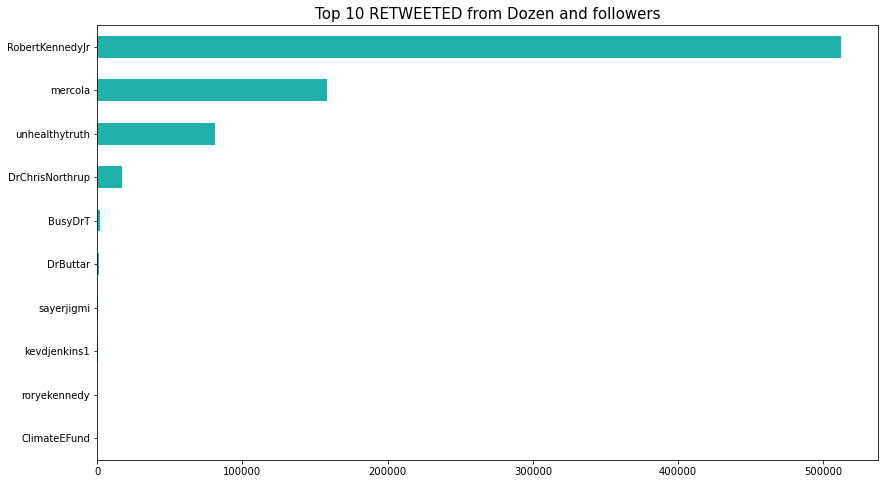

In [16]:
val = pd.Series(df["rt_user_screen_name"])
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:10].plot(kind='barh', color='lightseagreen', fig=(14,14)) #green #steelblue
ax.set_title('Top 10 RETWEETED from Bad Dozen and followers', fontsize=15)
ax.invert_yaxis()
plt.show()

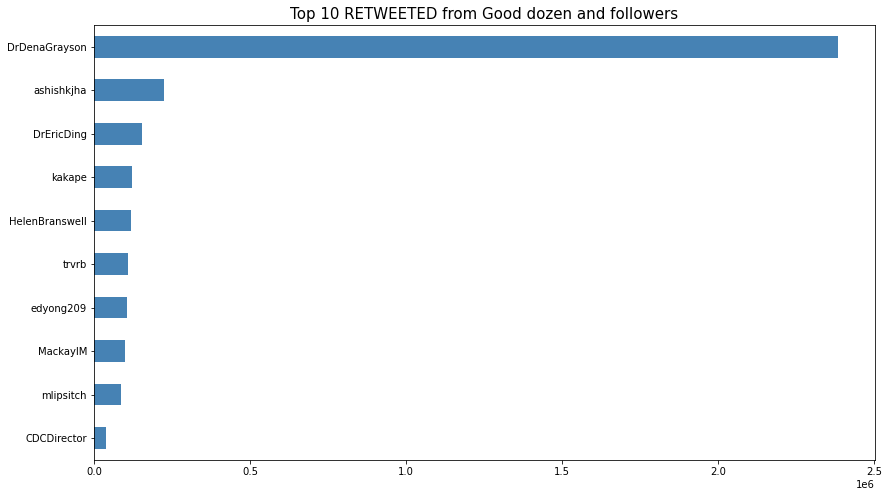

In [25]:
val = pd.Series(rt)
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:10].plot(kind='barh', color='steelblue', fig=(14,14)) #green #steelblue
ax.set_title('Top 10 RETWEETED from Good dozen and followers', fontsize=15)
ax.invert_yaxis()
plt.show()

### Self RT

In [ ]:
p2 = rt[rt["user_screen_name"].isin(list(good_dozen_list["screen_name"]))]
p2 = p2.reset_index(drop=True)

In [24]:
self_rt = []
for i in range(len(p2["user_screen_name"])):
    if(p2["user_screen_name"][i] == p2["rt_user_screen_name"][i]):
        self_rt.append(p2["user_screen_name"][i])
pd.Series(self_rt).value_counts().sort_values(ascending=False)

# Link shared by Dozen
<a id="link_sh"/>

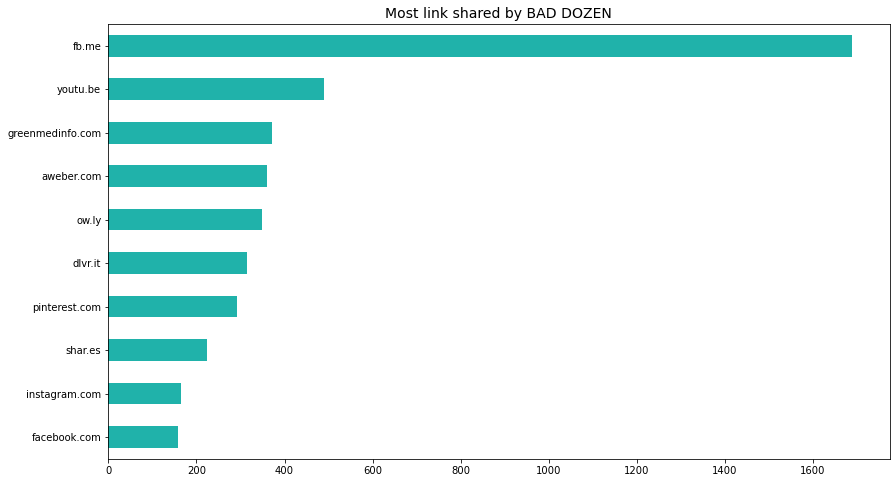

In [35]:
dozen_urls = df_bad_activity["urls"]
dozen_urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in dozen_urls]
dozen_urls = list(filter(lambda num: num != "0", dozen_urls))
dozen_urls = tweets_utils.remove_www(dozen_urls)
val = pd.Series(dozen_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='lightseagreen', fig=(14,14))
ax.set_title('Most link shared by BAD DOZEN', fontsize=14)
ax.invert_yaxis()
plt.show()

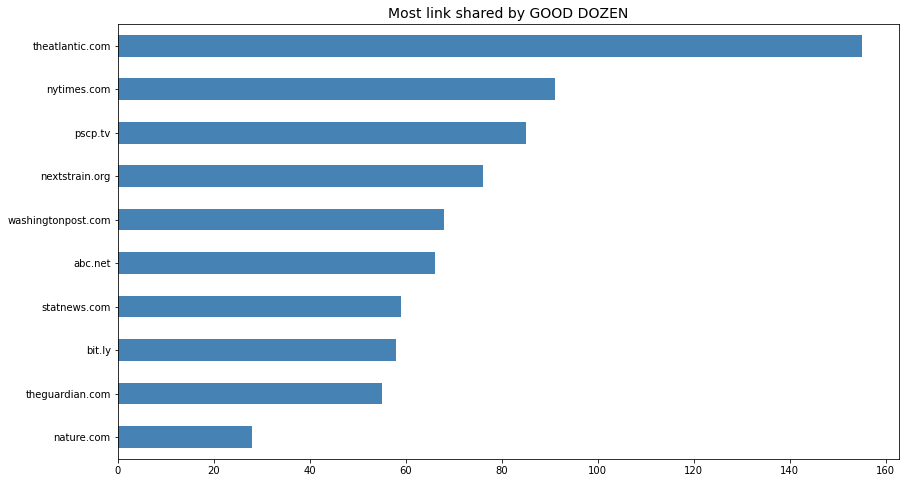

In [36]:
dozen_urls = df_good_activity["urls"]
dozen_urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in dozen_urls]
dozen_urls = list(filter(lambda num: num != "0", dozen_urls))
dozen_urls = tweets_utils.remove_www(dozen_urls)
val = pd.Series(dozen_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most link shared by GOOD DOZEN', fontsize=14)
ax.invert_yaxis()
plt.show()

# Link shared by users

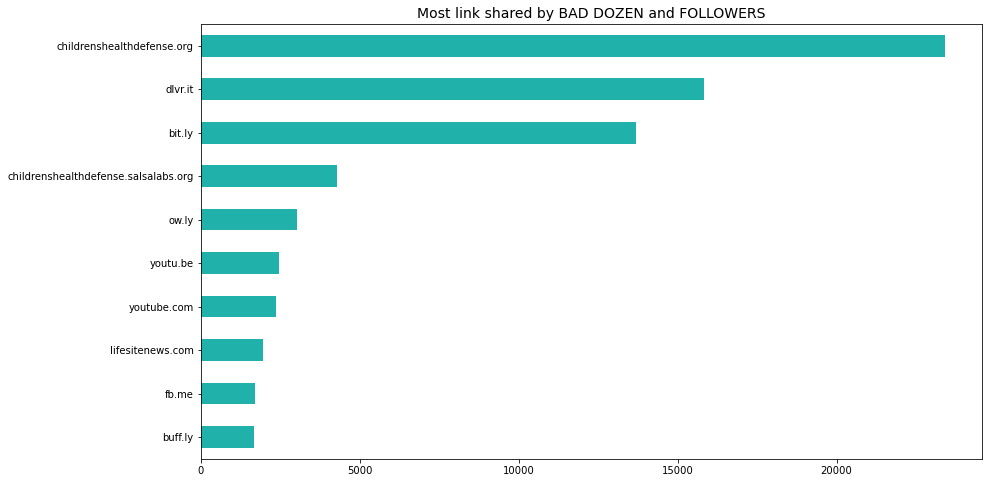

In [28]:
dozen_urls = df["urls"]
dozen_urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in dozen_urls]
dozen_urls = list(filter(lambda num: num != "0", dozen_urls))
dozen_urls = tweets_utils.remove_www(dozen_urls)
val = pd.Series(dozen_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='lightseagreen', fig=(14,14))
ax.set_title('Most link shared by BAD DOZEN and FOLLOWERS', fontsize=14)
ax.invert_yaxis()
plt.show()

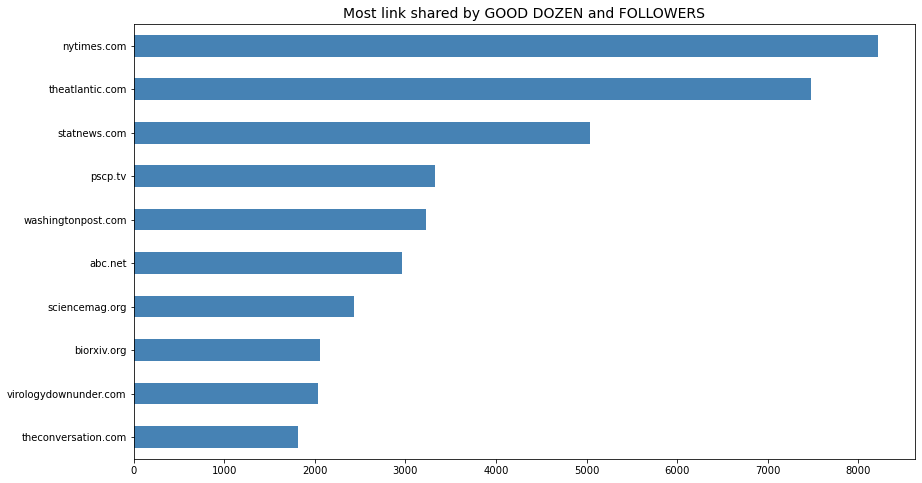

In [41]:
importlib.reload(tweets_utils)
dozen_urls = link
dozen_urls = [tweets_utils.url_decompress(v) if v != "[]" else "0" for v in dozen_urls]
dozen_urls = list(filter(lambda num: num != "0", dozen_urls))
dozen_urls = tweets_utils.remove_www(dozen_urls)
val = pd.Series(dozen_urls).value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[1:11].plot(kind='barh', color='steelblue', fig=(14,14))
ax.set_title('Most link shared by GOOD DOZEN and FOLLOWERS', fontsize=14)
ax.invert_yaxis()
plt.show()

# Hashtags
<a id="comp_hashtag"/>

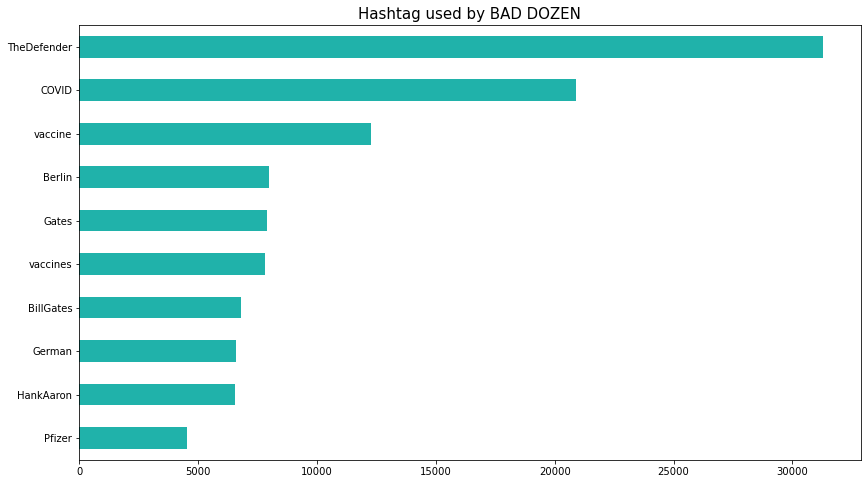

In [49]:
val = pd.Series(tweets_utils.hashtag_process(df))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:10].plot(kind='barh', color='lightseagreen', fig=(14,14)) #red #darkturquoise
ax.set_title('Hashtag used by BAD DOZEN', fontsize=15)
ax.invert_yaxis()
plt.show()

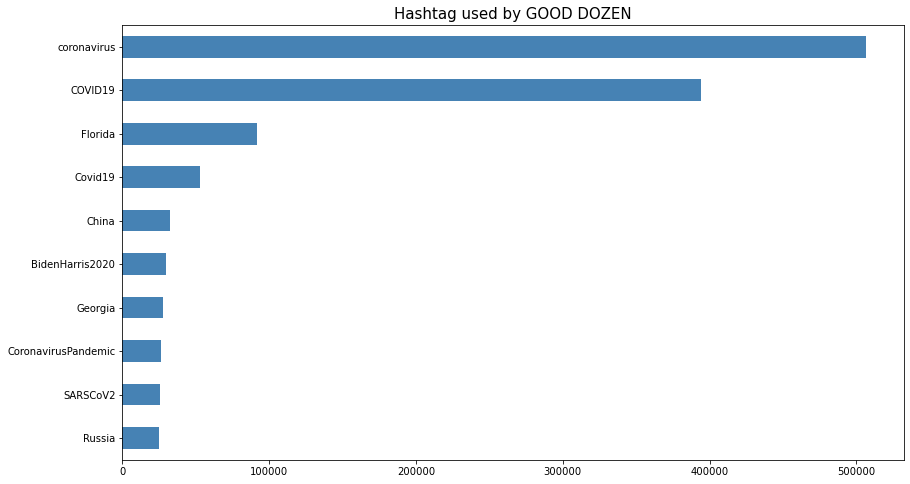

In [50]:
importlib.reload(tweets_utils)
val = pd.Series(tweets_utils.hashtag_process_list(hashtag))
val = val.value_counts().sort_values(ascending=False)
fig = plt.figure(figsize=(14, 8))
ax = val[:10].plot(kind='barh', color='steelblue', fig=(14,14)) #red #darkturquoise
ax.set_title('Hashtag used by GOOD DOZEN', fontsize=15)
ax.invert_yaxis()
plt.show()

# Credibility comparison
<a id="cred_comp"/>

In [104]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", x=x["perc"], name="Bad"))
fig.add_trace(go.Histogram(histfunc="sum", x=y["perc"], name="Good"))
fig.update_layout(
    title="Differences between Bad Dozen and Good Dozen credibility link shared",
    xaxis_title="Score",
    yaxis_title="Number of Users",
    legend_title="Legend")
fig.show()

# Interaction between Good and Bad Dozen
<a id="interaction"/>

In [107]:
df[df["in_reply_to_screen_name"].isin(list(good_dozen_list["screen_name"]))]

In [79]:
reply = pd.DataFrame()
for chunk in pd.read_csv(path[0] + "good_dozen_rt.csv", lineterminator='\n', low_memory=False, 
                         usecols=["id","user_screen_name", "in_reply_to_screen_name"], 
                         chunksize=int(1e6)):
    reply = reply.append(chunk)

In [112]:
reply[reply["in_reply_to_screen_name"].isin(list(bad_dozen_list["screen_name"]))]

In [77]:
reply_v[reply_v["in_reply_to_screen_name"].isin(list(bad_dozen_list["screen_name"]))]

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,user_tweets_count,user_friends_count,user_followers_count,...,quoted_status_text,quoted_status_created_at,quoted_user_id,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media


### Interaction between Good Dozen


In [84]:
reply_v = reply_v[["user_screen_name", "in_reply_to_screen_name"]]
reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_dozen_list["screen_name"]))]

,user_screen_name,in_reply_to_screen_name
13,DrDenaGrayson,DrDenaGrayson
14,DrDenaGrayson,DrDenaGrayson
15,DrDenaGrayson,DrDenaGrayson
16,DrDenaGrayson,DrDenaGrayson
71,DrDenaGrayson,DrDenaGrayson
...,...,...
38750,edyong209,edyong209
38789,edyong209,edyong209
38797,edyong209,edyong209
38831,edyong209,edyong209


### Interaction between Bad Dozen


In [88]:
reply = reply[["user_screen_name", "in_reply_to_screen_name"]]
reply[reply["in_reply_to_screen_name"].isin(list(bad_dozen_list["screen_name"]))]

,user_screen_name,in_reply_to_screen_name
109,mercola,mercola
123,mercola,mercola
128,mercola,mercola
160,mercola,mercola
161,mercola,mercola
...,...,...
16585,kevdjenkins1,kevdjenkins1
18211,kevdjenkins1,kevdjenkins1
18218,kevdjenkins1,kevdjenkins1
19196,BusyDrT,BusyDrT


# Reply investigation

In [97]:
x = reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_dozen_list["screen_name"]))]

In [99]:
x = x.reset_index(drop=True)
self_rep = []
for i in range(len(x["user_screen_name"])):
    if x["user_screen_name"][i] == x["in_reply_to_screen_name"][i]:
        self_rep.append(x["user_screen_name"][i])

In [103]:
f = pd.Series(self_rep).value_counts().sort_values(ascending=False)

In [104]:
value = 0
for i in f:
    value = value + i

In [108]:
len_internal_reply =len(reply_v[reply_v["in_reply_to_screen_name"].isin(list(good_dozen_list["screen_name"]))])
len_total_reply = len(reply_v)
print(f"Good dozen internal replies are {round(len_internal_reply/len_total_reply,4)*100}% of total")
print(f"Good dozen self-replies are {round(value/len_total_reply,4)*100}% of total")

Good dozen internal replies are 53.12% of total
Good dozen self-replies are 52.5% of total
